# Neural Network (Classification)
 
 - 3등 이내의 말을 찾는 모델을 구축 (연승식 베팅 가능)
 - 확률 형태의 결과값을 도출할 수 있음

## 전처리
 - 경기를 식별하기 위한 Groupid 부여
 - 결측치 있는 행은 제거
 - 말의 등급, 경기 등급, 습도 변수는 결측치가 많아 사용하지 않음
 - 말의 성별은 더미변수로 변환, 무게 및 속도 관련 변수는 표준화
 - 이전 3경기의 등수에 대한 정보는 평균으로 대체
 - 3등 이내 말의 rank는 1, 그 외는 0으로 재코딩

In [0]:
result = pd.read_csv('race_result.csv')

result = result.iloc[::-1]
result = result.reset_index().drop('index', axis=1)

# groupid 추가
result['groupid'] = result['date'].apply(str) + result['round'].apply(str)
idset = list(set(result['groupid']))
give_ids = dict(list(zip(idset, list(range(len(idset))))))
result['groupid'] = result['groupid'].apply(lambda x: give_ids[x])

# 필요 변수만 선택
result_df = result[ 
    ['date','round','groupid','rank', 'lane', 'sex', 'age','new_distance', 'prev1_rank', 'prev2_rank', 'prev3_rank', 'dandivi', 'yeondivi' ,
      'jockey_w', 'raw_weight', 'weight_added' , 'prev1_velo', 'prev2_velo', 'prev3_velo',
    'cure_in_1m', 'jprev1_rank', 'jprev2_rank', 'jprev3_rank']
]

# 결측치있는 raw 제거
result_nonan = result_df.dropna()

# sex 더미변수화
sex = pd.get_dummies(result_nonan.sex)
sex.columns = ['neut', 'male', 'female']
result_nonan = result_nonan.drop('sex', axis=1)
result_nonan = sex.join(result_nonan)

# weight, velocity 표준화
from sklearn import preprocessing
standadized_result = result_nonan[['jockey_w', 'raw_weight', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo']]
scaler = preprocessing.StandardScaler().fit(standadized_result)
preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
result_nonan[['jockey_w', 'raw_weight', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo']] = scaler.transform(standadized_result)

In [0]:
# 1~3등: 1, 나머지: 0
ranks_replace = {
    'rank': {'1': 1, '2': 1, '3': 1, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '실': None, '제': None, '중': None, '취': None},
    'prev1_rank' : {'실': None, '제': None, '중': None, '취': None},
    'prev2_rank' : {'실': None, '제': None, '중': None, '취': None},
    'prev3_rank' : {'실': None, '제': None, '중': None, '취': None},
    'jprev1_rank': {'실': None, '제': None, '중': None, '취': None}, 
    'jprev2_rank': {'실': None, '제': None, '중': None, '취': None},
    'jprev3_rank': {'실': None, '제': None, '중': None, '취': None}
}
result_binary = result_nonan.replace(ranks_replace, inplace=False)
result_binary = result_binary.dropna()

cols = ['prev1_rank','prev2_rank','prev3_rank','jprev1_rank','jprev2_rank','jprev3_rank']
result_binary[cols] = result_binary[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# prev_rank 평균으로 대체
result_binary['prev_rank_mean'] = (result_binary['prev1_rank']+result_binary['prev2_rank']+result_binary['prev3_rank'])/3
result_binary = result_binary.drop(['prev1_rank','prev2_rank','prev3_rank'], axis=1)

rank = result_binary['rank']
result_binary.drop(labels=['rank'], axis=1,inplace = True)
result_binary.insert(0, 'rank', rank)

## 학습데이터 분리
- 1) test set: 2017년 9월 ~ 2018년 9월 데이터, train set: 그 외 기간
- 2) test set: 2018년 3월 ~ 2018년 9월 데이터, train set: 그 외 기간
--------------
- 종속변수: rank 더미변수
- 설명변수: 'lane', 'sex', 'age','new_distance', 'dandivi', 'yeondivi' , 'jockey_w', 'raw_weight', 'weight_added' , 'prev1_velo', 'prev2_velo', 'prev3_velo', 'cure_in_1m', 'jprev1_rank', 'jprev2_rank', 'jprev3_rank', 'prev_rank_mean'

In [0]:
# test set 1) 2017.09 ~ 2018.09   2) 2018.03 ~ 2018.09
result_binary['year'] = pd.DatetimeIndex(result_binary['date']).year
result_binary['month'] = pd.DatetimeIndex(result_binary['date']).month
test_set1 = result_binary[((result_binary.year == 2017) & (result_binary.month >=9))|((result_binary.year == 2018) & (result_binary.month <=9))]
train_set1 = result_binary[((result_binary.year <= 2017) & (result_binary.month < 9))|((result_binary.year >= 2018) & (result_binary.month > 9))]
test_set2 = result_binary[(result_binary.year == 2018) & (result_binary.month >=3) & (result_binary.month <=9)]
train_set2 = result_binary[((result_binary.year <= 2018) & (result_binary.month < 3))|((result_binary.year >= 2018) & (result_binary.month > 9))]

# 모델에 불필요한 변수 drop
test1 = test_set1.drop(['date','round','groupid','year','month'],axis=1)
train1 = train_set1.drop(['date','round','groupid','year','month'],axis=1)
test2 = test_set2.drop(['date','round','groupid','year','month'],axis=1)
train2 = train_set2.drop(['date','round','groupid','year','month'],axis=1)

x_train = train2.iloc[:, 1:]
y_train = train2['rank'].astype(int)

x_test = test2.iloc[:, 1:]
y_test = test2['rank'].astype(int)

print_shape((x_train, y_train, x_test, y_test))

In [23]:
x_train.head()

neut  male  female  lane  age  new_distance  dandivi  yeondivi  jockey_w  \
0     0     0       1    11    4             0     40.2       8.3 -1.385726   
1     0     0       1     6    5             1     68.3      11.8  0.652003   
2     0     0       1     8    5             1      6.8       2.2 -0.876294   
3     0     1       0     4    4             1     66.4      10.6 -0.876294   
4     1     0       0     9    4             1     23.6       3.8  1.161435   

   raw_weight       ...        prev1_velo  prev2_velo  prev3_velo  cure_in_1m  \
0   -0.190196       ...          1.454755    1.701469   -2.634194           0   
1    0.194163       ...          0.040870   -1.325378    1.156693           1   
2   -0.432948       ...          1.643153    0.862988    0.551053           1   
3    0.720127       ...          0.210016    0.506775    0.816098           0   
4    0.093016       ...          0.727342    0.859280    2.010973           0   

   jprev1_rank  jprev2_rank  jprev3_rank  prev_velo_avg  prev_rank_avg  \
0            2            6            2      15.595166            2.0   
1            5            7            4      15.497170            1.0   
2            1            2            5      15.963258           11.0   
3           10            4            3      15.739252            3.0   
4            4            4            6      16.040071           12.0   

   prev_rank_mean  
0        6.000000  
1        6.000000  
2        4.666667  
3        5.333333  
4        3.333333  

[5 rows x 21 columns]

## Neural Network 모델 구축
### 모델 구성하기
- Python에서 신경망 모델을 쉽게 구축하게 해주는 딥러닝 라이브러리 Keras 사용
- `Batch Normalization`으로 모델 성능 개선
- `Dropout`으로 overfitting 방지
- 활성함수로 `sigmoid` 함수를 사용해 0과 1사이의 결과값 도출

In [0]:
from keras.models import Sequential
from keras.layers import Dense
import keras_metrics
import keras
import random
from sklearn.utils import class_weight
from keras import callbacks
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

xavier = keras.initializers.glorot_normal(seed=None)

model = Sequential()
model.add(Dense(32, input_dim=21, kernel_initializer=xavier, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout (0.2))
model.add(Dense(16, input_dim=21, kernel_initializer=xavier, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout (0.2))
model.add(Dense(1, activation='sigmoid'))

### 모델 학습시키기
- 성능이 가장 좋다고 알려진 adam optimizer 사용
- 종속변수가 불균형 데이터 (1~3등 비율이 전체 대비 적음) -> class_weight 옵션을 통해 해결 

### 학습과정 확인

In [33]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1score])

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

hist = model.fit(x_train, y_train, epochs=500, class_weight=class_weights)

Epoch 1/500
8081/8081 [==============================] - 1s 156us/step - loss: 0.5300 - acc: 0.7342 - recall: 0.3420 - precision: 0.5067 - f1score: 0.3832
Epoch 2/500
8081/8081 [==============================] - 0s 54us/step - loss: 0.4983 - acc: 0.7536 - recall: 0.3045 - precision: 0.5461 - f1score: 0.3728
Epoch 3/500
8081/8081 [==============================] - 0s 54us/step - loss: 0.4896 - acc: 0.7578 - recall: 0.2905 - precision: 0.5760 - f1score: 0.3637
Epoch 4/500
8081/8081 [==============================] - 0s 53us/step - loss: 0.4818 - acc: 0.7635 - recall: 0.3163 - precision: 0.5889 - f1score: 0.3920
Epoch 5/500
8081/8081 [==============================] - 0s 54us/step - loss: 0.4829 - acc: 0.7603 - recall: 0.3164 - precision: 0.5812 - f1score: 0.3887
Epoch 6/500
8081/8081 [==============================] - 0s 51us/step - loss: 0.4777 - acc: 0.7714 - recall: 0.3350 - precision: 0.6103 - f1score: 0.4128
Epoch 7/500
8081/8081 [==============================] - 0s 52us/step - los

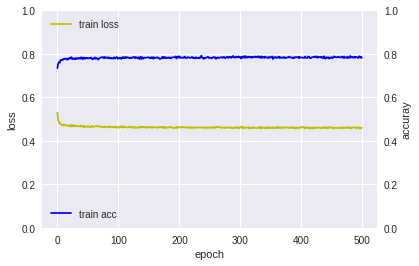

5162/5162 [==============================] - 0s 57us/step
loss_and_metrics : [0.49899591897541773, 0.7553273924835335, 0.3204356423185482, 0.6635178988499957, 0.41902422600132416]


In [34]:
# 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Threshold 설정 및 결과

test set 1 (2017년 9월 ~ 2018년 9월)

| Threshold | Precision | 예측값=1의 비율 |
| - - - - - | - - - - - | - - - - - - - |
|  0.6  | 0.77    | 0.04  |
|  0.5  | 0.68    | 0.13  |
|  0.4  | 0.59    | 0.22  |

test set 2 (2018년 3월 ~ 2018년 9월)

| Threshold | Precision | 예측값=1의 비율 |
| - - - - - | - - - - - | - - - - - - |
|  0.6  |  0.75 |  0.03 |
|  0.5  |  0.68 |  0.07 |
|  0.4  |  0.59 |  0.13 |

예측값이 1이 되는 경우의 비율도 고려해야 함. 1~3등을 예측하는 것이라 20~30%가 적절
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- 적절한 threshold에서 precision은 50%를 크게 벗어나지 않아 모델의 성능이 높지 않음
- 모델 파라미터 설정에 따라 overfitting 또는 underfitting이 쉽게 일어나 적절한 파라미터를 찾기 어려움
- 현 모델은 또한 경기 맥락을 충분히 고려하지 못한다는 한계를 가짐

In [38]:
pred = model.predict(x_test)
yt = np.array(y_test)
predictions = [0 for x in range(pred.shape[0])]
for i, predicted in enumerate(pred):
    if predicted[0] >= 0.4:
        predictions[i] = 1
    else:
        predictions[i] = 0
        
df = pd.DataFrame({'prediction' : predictions, 'real' : yt})
df['accurate'] = df['prediction'] == df['real']

display(
    df[df['prediction'] == 1].shape[0] / df.shape[0],
    df[df['prediction'] == 1].accurate.mean()
)

0.23266175900813638

0.5970024979184013